# Snow Pit Data Access and SWE Calculation

This notebook is designed to access data from snow pits gathered during the SnowEx field campaigns. There are two embedded examples: a simple use case with `earthaccess` and snow depth data, and a more advanced example using the SnowEx database (`snowexsql`) to obtain snow depth and density.

Note that the `snowexsql` example is currently a work in progress, using code from a SnowEx Database example found here: https://snowexsql.readthedocs.io/en/latest/gallery/plot_pit_swe_example.html

In [9]:
!pip install contextily cmcrameri
!pip install snowexsql -U

In [5]:
import earthaccess
import pandas as pd
import geopandas as gpd
import os
import tempfile
from shapely.geometry import Point
import shutil
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import contextily as ctx

## earthaccess example
For the earthaccess example, we are using the DOI of the "SnowEx20 Community Snow Depth Probe Measurements, Version 1" obtained at Grand Mesa, CO. These files are stored in CSV format, and contain snow depths using magnaprobes, Mesa2 tablets, and pit rulers.

Note that the `short_name` of the dataset is provided in the cell. This may be used as an alternative to the DOI, if desired.

In [3]:
# Authenticate with Earthdata Login servers
auth = earthaccess.login(strategy="interactive")

# Search for granules
results = earthaccess.search_data(
    #short_name="SNEX20_SD",
    doi = "10.5067/9IA978JIACAR",
    temporal=('2020-01-01', '2020-03-01'),
)

In [4]:
display(results[0])

Collection: {'EntryTitle': 'SnowEx20 Community Snow Depth Probe Measurements V001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -108.228, 'Latitude': 39.0}, {'Longitude': -107.997, 'Latitude': 39.0}, {'Longitude': -107.997, 'Latitude': 39.067}, {'Longitude': -108.228, 'Latitude': 39.067}, {'Longitude': -108.228, 'Latitude': 39.0}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-01-28T00:00:01.000Z', 'EndingDateTime': '2020-02-12T23:59:59.000Z'}}
Size(MB): 3.30684
Data: ['https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/SNEX20_SD.001/2020.01.28/SnowEx2020_SnowDepths_COGM_alldepths_v01.csv']

Our query returned a single CSV file over the time frame of interest. Note how we did not include a spatial bound for the data here - this is because the dataset of interest only gathered data over Grand Mesa, CO.

To obtain the data, we will create a temporary directory (`tempfile.mkdtemp()`), and load the data into a GeoDataFrame. The temporary directory (and data within) will be deleted after processing.

In [5]:
# Create a temporary directory for downloads
temp_dir = tempfile.mkdtemp()
print(f"Using temporary directory: {temp_dir}")

# Download the data to the temp directory
downloaded_files = earthaccess.download(
    results,
    local_path=temp_dir,
)
print(f"Downloaded {len(downloaded_files)} files to {temp_dir}")

# Process CSV files and convert to GeoDataFrame
gdf = gpd.GeoDataFrame()
csv_files = [file for file in downloaded_files if file.endswith('.csv')]
if csv_files:
    for i, csv_file in enumerate(csv_files):
        print(f"Processing: {os.path.basename(csv_file)}")

        # Read the csv file
        tmp_df = pd.read_csv(csv_file)

        # Convert to GeoDataFrame
        geometry = [Point(xy) for xy in zip(tmp_df['Easting'], tmp_df['Northing'])]
        tmp_gdf = gpd.GeoDataFrame(tmp_df, geometry=geometry, crs="EPSG:32612")

        # Add to final GeoDataFrame
        gdf = pd.concat([gdf, tmp_gdf])

print("All files processed.")
print(' ')
print(f"Removing temporary directory: {temp_dir}")
shutil.rmtree(temp_dir)

Using temporary directory: /tmp/tmpt_58rbdj


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Downloaded 1 files to /tmp/tmpt_58rbdj
Processing: SnowEx2020_SnowDepths_COGM_alldepths_v01.csv
All files processed.
 
Removing temporary directory: /tmp/tmpt_58rbdj


Fast and easy! We can now check out the contents of the data.

In [6]:
gdf.head()

,Measurement Tool (MP = Magnaprobe; M2 = Mesa 2; PR = Pit Ruler),ID,Date (yyyymmdd),"Time (hh:mm, local, MST)",PitID,Longitude,Latitude,Easting,Northing,Depth (cm),elevation (m),equipment,Version Number,geometry
0,MP,100000,20200128,11:48,8N58,-108.13515,39.03045,747987.62,4324061.71,94,3148.2,CRREL_B,1,POINT (747987.62 4324061.71)
1,MP,100001,20200128,11:48,8N58,-108.13516,39.03045,747986.75,4324061.68,74,3148.3,CRREL_B,1,POINT (747986.75 4324061.68)
2,MP,100002,20200128,11:48,8N58,-108.13517,39.03045,747985.89,4324061.65,90,3148.2,CRREL_B,1,POINT (747985.89 4324061.65)
3,MP,100003,20200128,11:48,8N58,-108.13519,39.03044,747984.19,4324060.49,87,3148.6,CRREL_B,1,POINT (747984.19 4324060.49)
4,MP,100004,20200128,11:48,8N58,-108.13519,39.03042,747984.26,4324058.27,90,3150.1,CRREL_B,1,POINT (747984.26 4324058.27)


Some columns of interest include:
* `Measurement Tool [...]`: The measurement tool used to measure snow depth: MP = magnaprobe, M2 = Mesa2 tablet, and PR = pit ruler.
* `Date [...]`: The date of the measurement, in yyyymmdd format.
* `PitID`: The designated pit ID associated with the measurement.
* `Depth (cm)`: Snow depth, in centimeters.
* `elevation (m)`: Surface elevation at the location of the measurement.

The key variables for this example - the measurement approach and the depth - could use renaming. Let's do that now.

In [7]:
gdf.rename(columns={"Measurement Tool (MP = Magnaprobe; M2 = Mesa 2; PR = Pit Ruler)": 'measurement_tool',
                    "Depth (cm)": 'snow_depth'}, inplace=True
          )

Now, let's make a map plot showing the locations of the measurements, colored by snow depth value.

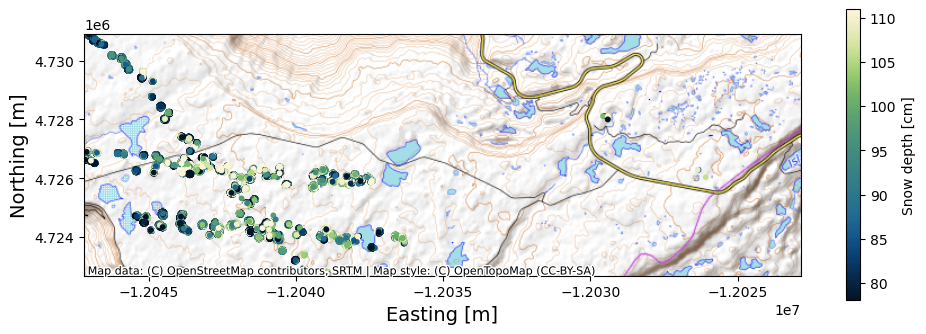

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

# Define min/max values for colormap
vmin = gdf['snow_depth'].quantile(0.15)
vmax = gdf['snow_depth'].quantile(0.85)

# Convert to EPSG:3857 to match with the contextily basemap
if gdf.crs != 'EPSG:3857':
    gdf_web = gdf.to_crs(epsg=3857)
    ax.set_xlim(gdf_web.total_bounds[[0, 2]])
    ax.set_ylim(gdf_web.total_bounds[[1, 3]])
else:
    ax.set_xlim(gdf.total_bounds[[0, 2]])
    ax.set_ylim(gdf.total_bounds[[1, 3]])

# Plot snow depths by location
gdf_web.plot(
    column='snow_depth',
    ax=ax,
    markersize=10,
    cmap='cmc.navia',
    legend=True,
    legend_kwds={'shrink': 0.3, 'label': 'Snow depth [cm]'},
    vmin=vmin,
    vmax=vmax
)

# Add topographic map for spatial reference
ctx.add_basemap(
    ax, 
    source=ctx.providers.OpenTopoMap,
    zoom='auto'
)

ax.set_xlabel("Easting [m]", fontsize=14)
ax.set_ylabel("Northing [m]", fontsize=14)
plt.tight_layout()
plt.show()

The above map looks pretty cool, but we might be interested to see how the different measurement approaches differ in accuracy and uncertainty. Let's now use `seaborn` to generate snow depth histograms for each instrument.

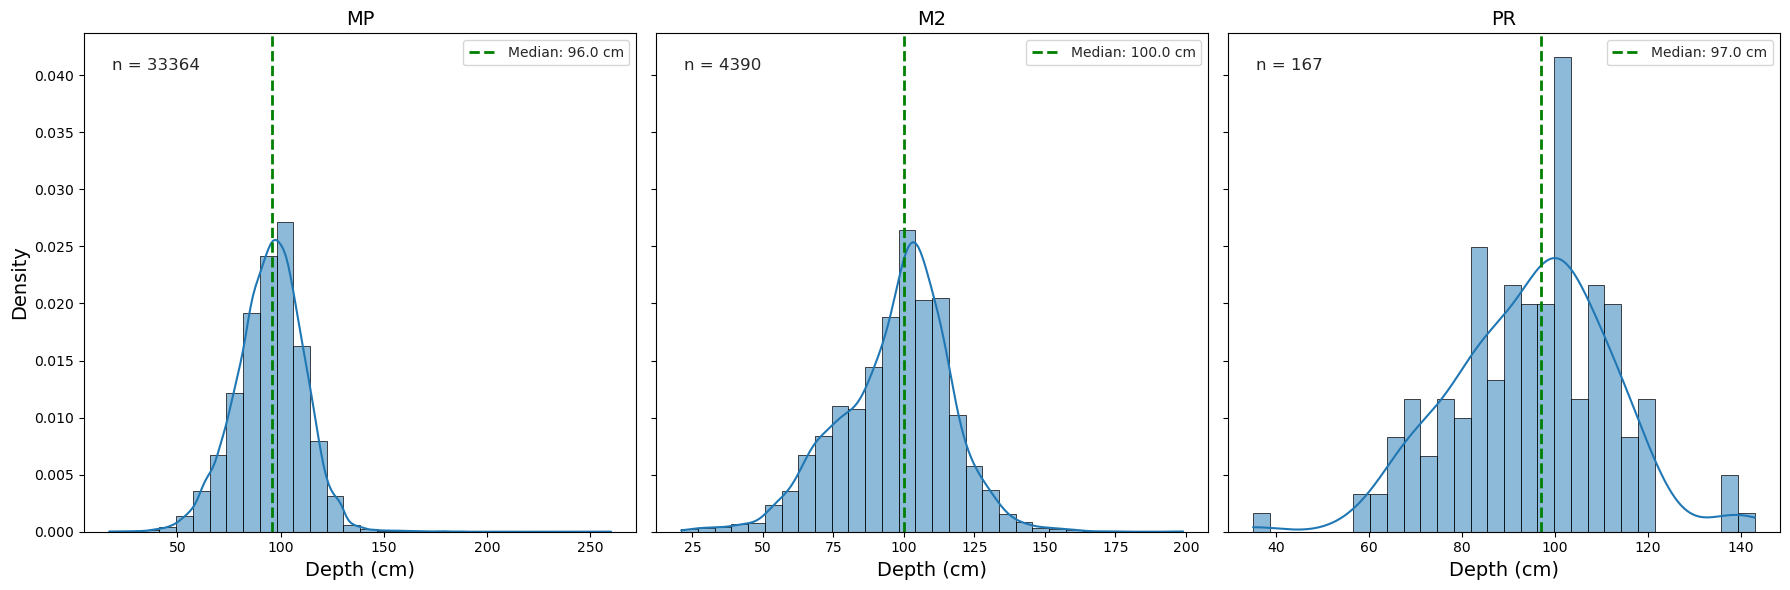

In [9]:
import seaborn as sns

# Get the unique measurement values
unique_measurements = gdf['measurement_tool'].unique()

# Make 1x3 figure for each tool
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
# Set consistent background
sns.set_style("whitegrid")

# Loop through unique measurement tools to make a plot for each
for i, measurement in enumerate(unique_measurements):
    subset = gdf[gdf['measurement_tool']==measurement]

    # Make a KDE plot normalized by density, rather than raw counts
    sns.histplot(subset['snow_depth'],
                 ax=axs[i],
                 kde=True,
                 bins=30,
                 edgecolor='black',
                 linewidth=0.5,
                 stat="density",
                 common_norm=False
                )

    # Draw a vertical line at the median snow depth
    median_val = subset['snow_depth'].median()
    axs[i].axvline(median_val, color='green', linestyle='--', linewidth=2,
                   label=f'Median: {median_val} cm')

    # Add text that notes the total number of measurements
    axs[i].text(
            0.05, 0.95,
            f"n = {len(subset)}",
            transform=axs[i].transAxes,
            fontsize=12,
            verticalalignment='top'
    )

    axs[i].set_title(f'{measurement}', fontsize=14)
    axs[i].set_xlabel("Depth (cm)", fontsize=14)

    # Set y-label only for first figure
    if i == 0:
        axs[i].set_ylabel("Density", fontsize=14)
    else:
        axs[i].set_ylabel(" ")

    axs[i].legend(loc='upper right')

plt.tight_layout()
plt.show()

Thanks to this plot, we can make a comparison between the different instruments. The magnaprobe depths are the lowest by a slight margin, and also appear to have the lowest spread in depths. The Mesa2 tablet depths are the highest by a few centimeters, and the pit rulers have the highest spread.

## SnowEx Database Example
(work in progress)

In [1]:
from snowexsql.api import PointMeasurements, LayerMeasurements

# Instantiate the class to use the properties!
measurements = PointMeasurements()

# Get the unique data names/types in the table
results = measurements.all_types
print('Available types = {}'.format(', '.join([str(r) for r in results])))

# Get the unique instrument in the table
results = measurements.all_instruments
print('\nAvailable Instruments = {}'.format(', '.join([str(r) for r in results])))

# Get the unique dates in the table
results = measurements.all_dates
print('\nAvailable Dates = {}'.format(', '.join(sorted([str(r) for r in results]))))

# Get the unique site names in the table
results = measurements.all_site_names
print('\nAvailable sites = {}'.format(', '.join([str(r) for r in results])))

Available types = two_way_travel, snow_void, density, swe, depth

Available Instruments = mesa, magnaprobe, camera, pulseEkko pro 1 GHz GPR, Mala 1600 MHz GPR, None, Mala 800 MHz GPR, pulse EKKO Pro multi-polarization 1 GHz GPR, pit ruler

Available Dates = 2019-09-29, 2019-09-30, 2019-10-01, 2019-10-02, 2019-10-03, 2019-10-04, 2019-10-05, 2019-10-06, 2019-10-07, 2019-10-08, 2019-10-09, 2019-10-10, 2019-10-11, 2019-10-12, 2019-10-13, 2019-10-14, 2019-10-15, 2019-10-16, 2019-10-17, 2019-10-18, 2019-10-19, 2019-10-20, 2019-10-21, 2019-10-22, 2019-10-23, 2019-10-24, 2019-10-25, 2019-10-26, 2019-10-27, 2019-10-28, 2019-10-29, 2019-10-30, 2019-10-31, 2019-11-01, 2019-11-02, 2019-11-03, 2019-11-04, 2019-11-05, 2019-11-06, 2019-11-07, 2019-11-08, 2019-11-09, 2019-11-10, 2019-11-11, 2019-11-12, 2019-11-13, 2019-11-14, 2019-11-15, 2019-11-16, 2019-11-17, 2019-11-18, 2019-11-19, 2019-11-20, 2019-11-21, 2019-11-22, 2019-11-23, 2019-11-24, 2019-11-25, 2019-11-26, 2019-11-27, 2019-11-28, 2019-11-29

In [14]:
# Pick the first one we find
#site_id = LayerMeasurements().all_site_ids
site_id = LayerMeasurements()

# Query the database, we only need one point to get a site id and its geometry
#site_df = LayerMeasurements.from_filter(site_id=site_id, limit=1)

# Print it out 
site_id.all_site_ids

['1N1',
 '1N3',
 '8N45',
 '9N39',
 '8C35',
 'COGM8C11_20200205',
 '5N24',
 'Mores Mountain',
 'FLCF',
 '1C7',
 '7N40',
 'SNB 2',
 '8N55',
 'CLPX Fool Creek 02',
 'Lower Deer Point - Tree',
 'COGM1N23_20200211',
 '5N10',
 'GML',
 'CLPX St. Louis 06',
 'SnowEx B 2',
 'SnowEx-1',
 '8S41',
 'COGM3N22_20200128',
 'Forest 14',
 '6S53',
 '8C11',
 'COGM2N12_20200131',
 'COGM2S48_20200129',
 'Open Flat',
 'Joe Wright',
 '7S23',
 'JPL SoOp 1',
 'COGM8N25_20200128',
 'Open 2',
 '5S42',
 'Mesa West Open',
 'CLPX Fool Creek 12',
 'COGM5S43_20200129',
 '2S35',
 '1S17',
 '1C8',
 'FL2A',
 'Caples Lake',
 'Open 4',
 '8S28',
 '2C33',
 '6N46',
 '8N35',
 '6S15',
 '3S14',
 'TLSFL2A',
 '2N13',
 '3N26',
 'Banner Open',
 'Training',
 '3S52',
 '4N2',
 '2S9',
 'COGM2N13_20200206',
 'Trench 13',
 'CLPX Fool Creek 04',
 '6C24',
 'Panorama Dome',
 'Wx',
 '5C27',
 'FL1B',
 '1N6',
 'CLPX St. Louis 12',
 '2N8',
 'COGM3S14_20200201',
 '9N59',
 'COGM9S51_20200129',
 'CLPX St. Louis 07',
 '8C25',
 '8N58',
 '7S50',
 '2N4

In [4]:
data_type = 'depth'

In [ ]:
import pandas as pd
site_df = pd.DataFrame()
for site in LayerMeasurements().all_site_ids:
    tmp = PointMeasurements.from_filter(site_id=site, type='depth', limit=1)
    try:
        tmp = tmp.to_crs("EPSG:4326")
    except:
        tmp = tmp.set_crs("EPSG:4326")

    site_df = pd.concat([site_df, tmp])

# Pick the first one we find
#site_id = LayerMeasurements().all_site_ids

# Query the database, we only need one point to get a site id and its geometry
#site_df = LayerMeasurements.from_filter(site_id=site_id)

# Print it out 
#site_df

In [ ]:
site_df.explore()

In [ ]:
site_df['site_id'][site_df['id']==7643177].values

In [2]:
# Import in our two classes to access the db
from snowexsql.api import LayerMeasurements
from datetime import datetime 

# Find some density pit measurements at the Boise site in december 2019.
magnaprobe = measurements.from_filter(
    type="depth",
    site_name="Grand Mesa",
    instrument="magnaprobe",
    date_less_equal=datetime(2020, 3, 1),
    date_greater_equal=datetime(2020, 1, 1),
    limit=38000
)

In [3]:
magnaprobe.head()

,version_number,equipment,value,latitude,longitude,northing,easting,elevation,utm_zone,geom,...,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,observers
0,1,CRREL_B,93.0,39.02992,-108.13744,4.323997e+06,747791.209736,3148.9,12,POINT (747791.21 4323996.63),...,2020-01-28,2022-06-30 22:56:52.635035+00:00,None,4498,https://doi.org/10.5067/9IA978JIACAR,2022-06-30,magnaprobe,depth,cm,None
1,1,CRREL_B,76.0,39.02991,-108.13747,4.323995e+06,747788.647353,3149.2,12,POINT (747788.647 4323995.439),...,2020-01-28,2022-06-30 22:56:52.635035+00:00,None,4499,https://doi.org/10.5067/9IA978JIACAR,2022-06-30,magnaprobe,depth,cm,None
2,1,CRREL_B,94.0,39.02992,-108.13751,4.323996e+06,747785.149288,3148.8,12,POINT (747785.149 4323996.44),...,2020-01-28,2022-06-30 22:56:52.635035+00:00,None,4500,https://doi.org/10.5067/9IA978JIACAR,2022-06-30,magnaprobe,depth,cm,None
3,1,CRREL_B,81.0,39.02993,-108.13752,4.323998e+06,747784.248559,3147.7,12,POINT (747784.249 4323997.522),...,2020-01-28,2022-06-30 22:56:52.635035+00:00,None,4501,https://doi.org/10.5067/9IA978JIACAR,2022-06-30,magnaprobe,depth,cm,None
4,1,CRREL_B,54.0,39.02993,-108.13754,4.323997e+06,747782.517002,3147.2,12,POINT (747782.517 4323997.468),...,2020-01-28,2022-06-30 22:56:52.635035+00:00,None,4502,https://doi.org/10.5067/9IA978JIACAR,2022-06-30,magnaprobe,depth,cm,None


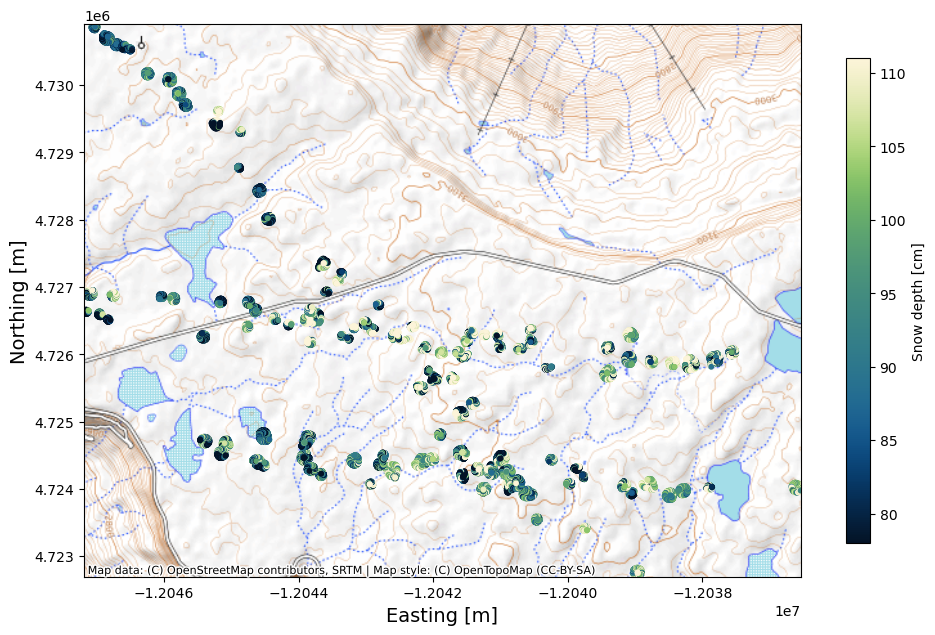

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

# Define min/max values for colormap
vmin = magnaprobe['value'].quantile(0.15)
vmax = magnaprobe['value'].quantile(0.85)

# Convert to EPSG:3857 to match with the contextily basemap
if magnaprobe.crs != 'EPSG:3857':
    gdf_web = magnaprobe.to_crs(epsg=3857)
    ax.set_xlim(gdf_web.total_bounds[[0, 2]])
    ax.set_ylim(gdf_web.total_bounds[[1, 3]])
else:
    gdf_web = magnaprobe
    ax.set_xlim(gdf.total_bounds[[0, 2]])
    ax.set_ylim(gdf.total_bounds[[1, 3]])

# Plot snow depths by location
gdf_web.plot(
    column='value',
    ax=ax,
    markersize=10,
    cmap='cmc.navia',
    legend=True,
    legend_kwds={'shrink': 0.5, 'label': 'Snow depth [cm]'},
    vmin=vmin,
    vmax=vmax
)

# Add topographic map for spatial reference
ctx.add_basemap(
    ax, 
    source=ctx.providers.OpenTopoMap,
    zoom='auto'
)

ax.set_xlabel("Easting [m]", fontsize=14)
ax.set_ylabel("Northing [m]", fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
# Make a query for the Mesa2 tablets
mesa2 = measurements.from_filter(
    type="depth",
    site_name="Grand Mesa",
    instrument="mesa",
    date_less_equal=datetime(2020, 3, 1),
    date_greater_equal=datetime(2020, 1, 1),
    limit=38000
)

print(f"Found {len(mesa2)} Mesa2 tablet measurements.")

# Do the same for pit ruler measurements
pit_ruler = measurements.from_filter(
    type="depth",
    site_name="Grand Mesa",
    instrument="pit ruler",
    date_less_equal=datetime(2020, 3, 1),
    date_greater_equal=datetime(2020, 1, 1),
    limit=38000
)

print(f"Found {len(pit_ruler)} pit ruler measurements.")

Found 4390 Mesa2 tablet measurements.
Found 158 pit ruler measurements.


In [10]:
mesa2.head()

,version_number,equipment,value,latitude,longitude,northing,easting,elevation,utm_zone,geom,...,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,observers
0,1,Mesa2_1,102.0,39.03367,-108.19004,4.324271e+06,743224.371084,3060.91,12,POINT (743224.371 4324270.802),...,2020-01-28,2022-06-30 22:56:52.635035+00:00,None,37434,https://doi.org/10.5067/9IA978JIACAR,2022-06-30,mesa,depth,cm,None
1,1,Mesa2_1,123.0,39.03364,-108.18998,4.324268e+06,743229.668365,3060.90,12,POINT (743229.668 4324267.633),...,2020-01-28,2022-06-30 22:56:52.635035+00:00,None,37435,https://doi.org/10.5067/9IA978JIACAR,2022-06-30,mesa,depth,cm,None
2,1,Mesa2_1,123.0,39.03359,-108.18993,4.324262e+06,743234.168551,3060.98,12,POINT (743234.169 4324262.216),...,2020-01-28,2022-06-30 22:56:52.635035+00:00,None,37436,https://doi.org/10.5067/9IA978JIACAR,2022-06-30,mesa,depth,cm,None
3,1,Mesa2_1,114.0,39.03353,-108.18993,4.324256e+06,743234.374426,3060.53,12,POINT (743234.374 4324255.556),...,2020-01-28,2022-06-30 22:56:52.635035+00:00,None,37437,https://doi.org/10.5067/9IA978JIACAR,2022-06-30,mesa,depth,cm,None
4,1,Mesa2_1,117.0,39.03347,-108.18995,4.324249e+06,743232.848848,3060.49,12,POINT (743232.849 4324248.843),...,2020-01-28,2022-06-30 22:56:52.635035+00:00,None,37438,https://doi.org/10.5067/9IA978JIACAR,2022-06-30,mesa,depth,cm,None


In [11]:
gdf = pd.concat([magnaprobe, mesa2, pit_ruler])

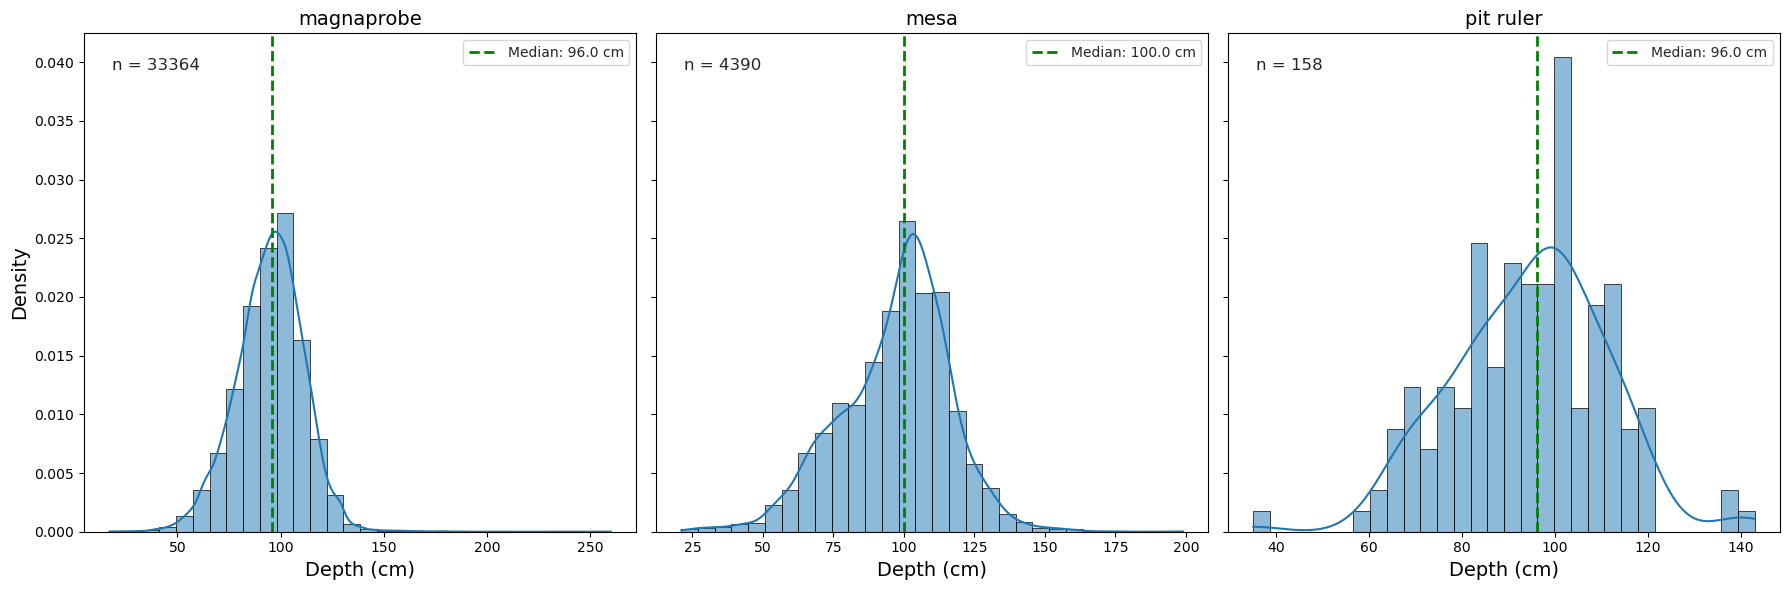

In [12]:
import seaborn as sns

# Get the unique measurement values
unique_measurements = gdf['instrument'].unique()

# Make 1x3 figure for each tool
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
# Set consistent background
sns.set_style("whitegrid")

# Loop through unique measurement tools to make a plot for each
for i, measurement in enumerate(unique_measurements):
    subset = gdf[gdf['instrument']==measurement]

    # Make a KDE plot normalized by density, rather than raw counts
    sns.histplot(subset['value'],
                 ax=axs[i],
                 kde=True,
                 bins=30,
                 edgecolor='black',
                 linewidth=0.5,
                 stat="density",
                 common_norm=False
                )

    # Draw a vertical line at the median snow depth
    median_val = subset['value'].median()
    axs[i].axvline(median_val, color='green', linestyle='--', linewidth=2,
                   label=f'Median: {median_val} cm')

    # Add text that notes the total number of measurements
    axs[i].text(
            0.05, 0.95,
            f"n = {len(subset)}",
            transform=axs[i].transAxes,
            fontsize=12,
            verticalalignment='top'
    )

    axs[i].set_title(f'{measurement}', fontsize=14)
    axs[i].set_xlabel("Depth (cm)", fontsize=14)

    # Set y-label only for first figure
    if i == 0:
        axs[i].set_ylabel("Density", fontsize=14)
    else:
        axs[i].set_ylabel(" ")

    axs[i].legend(loc='upper right')

plt.tight_layout()
plt.show()